In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

d:\CS 6120\Final Project\cs6010_fa2024_project_g06\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
# List of relevant columns
columns_to_use = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
                  'trip_distance','payment_type','fare_amount']

In [7]:
df2024_1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet', columns=columns_to_use)
df2024_2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet', columns=columns_to_use)
df2024_3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet', columns=columns_to_use)
df2024_4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet', columns=columns_to_use)
df2024_5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet', columns=columns_to_use)
df2024_6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet', columns=columns_to_use)

df2024 = pd.concat([df2024_1, df2024_2, df2024_3, df2024_4, df2024_5, df2024_6])

In [8]:
df2024.shape

(20332093, 6)

In [9]:
df2024.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
count,20332093,20332093,1.835611e+07,2.033209e+07,2.033209e+07,2.033209e+07
mean,2024-04-04 15:46:48.415694,2024-04-04 16:03:41.511144,1.332897e+00,4.704865e+00,1.102157e+00,1.888715e+01
min,2002-12-31 16:46:07,2002-12-31 17:24:07,0.000000e+00,0.000000e+00,0.000000e+00,-1.285400e+03
25%,2024-02-21 21:43:17,2024-02-21 21:56:08,1.000000e+00,1.020000e+00,1.000000e+00,9.300000e+00
50%,2024-04-05 20:57:06,2024-04-05 21:11:56,1.000000e+00,1.750000e+00,1.000000e+00,1.350000e+01
75%,2024-05-18 02:57:44,2024-05-18 03:10:54,1.000000e+00,3.300000e+00,1.000000e+00,2.190000e+01
max,2026-06-26 23:53:12,2026-06-27 20:59:10,9.000000e+00,3.127223e+05,5.000000e+00,3.340763e+05
std,NaN,NaN,8.304837e-01,3.592496e+02,6.315719e-01,7.728530e+01


In [10]:
#check memory usage
df2024.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 20332093 entries, 0 to 3539192
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   payment_type           int64         
 5   fare_amount            float64       
dtypes: datetime64[us](2), float64(3), int64(1)
memory usage: 1.1 GB


In [11]:
float_cols = df2024.select_dtypes(include=['float64']).columns
int_cols = df2024.select_dtypes(include=['int64']).columns

df2024[float_cols] = df2024[float_cols].astype(np.float32)
df2024[int_cols] = df2024[int_cols].astype(np.int32)

In [12]:
#check memory usage
df2024.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 20332093 entries, 0 to 3539192
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float32       
 3   trip_distance          float32       
 4   payment_type           int32         
 5   fare_amount            float32       
dtypes: datetime64[us](2), float32(3), int32(1)
memory usage: 775.6 MB


In [19]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    'duplicate' : df2024.duplicated().sum(),
    'min': [df2024[col].min() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'max': [df2024[col].max() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'n_unique': df2024.nunique().values,
    'sample_unique': [df2024[col].unique() for col in df2024.columns]}
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,min,max,n_unique,sample_unique
0,tpep_pickup_datetime,datetime64[us],0.000,0.000,0.000,973,NaN,NaN,9955675,"[2024-01-01 00:57:55, 2024-01-01 00:03:00, 202..."
1,tpep_dropoff_datetime,datetime64[us],0.000,0.000,0.000,973,NaN,NaN,9948395,"[2024-01-01 01:17:43, 2024-01-01 00:09:36, 202..."
2,passenger_count,float32,9.719,0.000,1.087,973,0.0,9.000,10,"[1.0, 2.0, 0.0, 4.0, 3.0, 5.0, 6.0, 8.0, 7.0, ..."
3,trip_distance,float32,0.000,0.000,1.792,973,0.0,312722.312,7056,"[1.72, 1.8, 4.7, 1.4, 0.8, 10.82, 3.0, 5.44, 0..."
4,payment_type,int32,0.000,0.000,9.719,973,0.0,5.000,6,"[2, 1, 4, 3, 0, 5]"
5,fare_amount,float32,0.000,1.553,0.041,973,-1285.4,334076.312,14681,"[17.7, 10.0, 23.3, 7.9, 29.6, 45.7, 25.4, 31.0..."


In [20]:
df2024.reset_index(drop=True, inplace=True)

## EDA

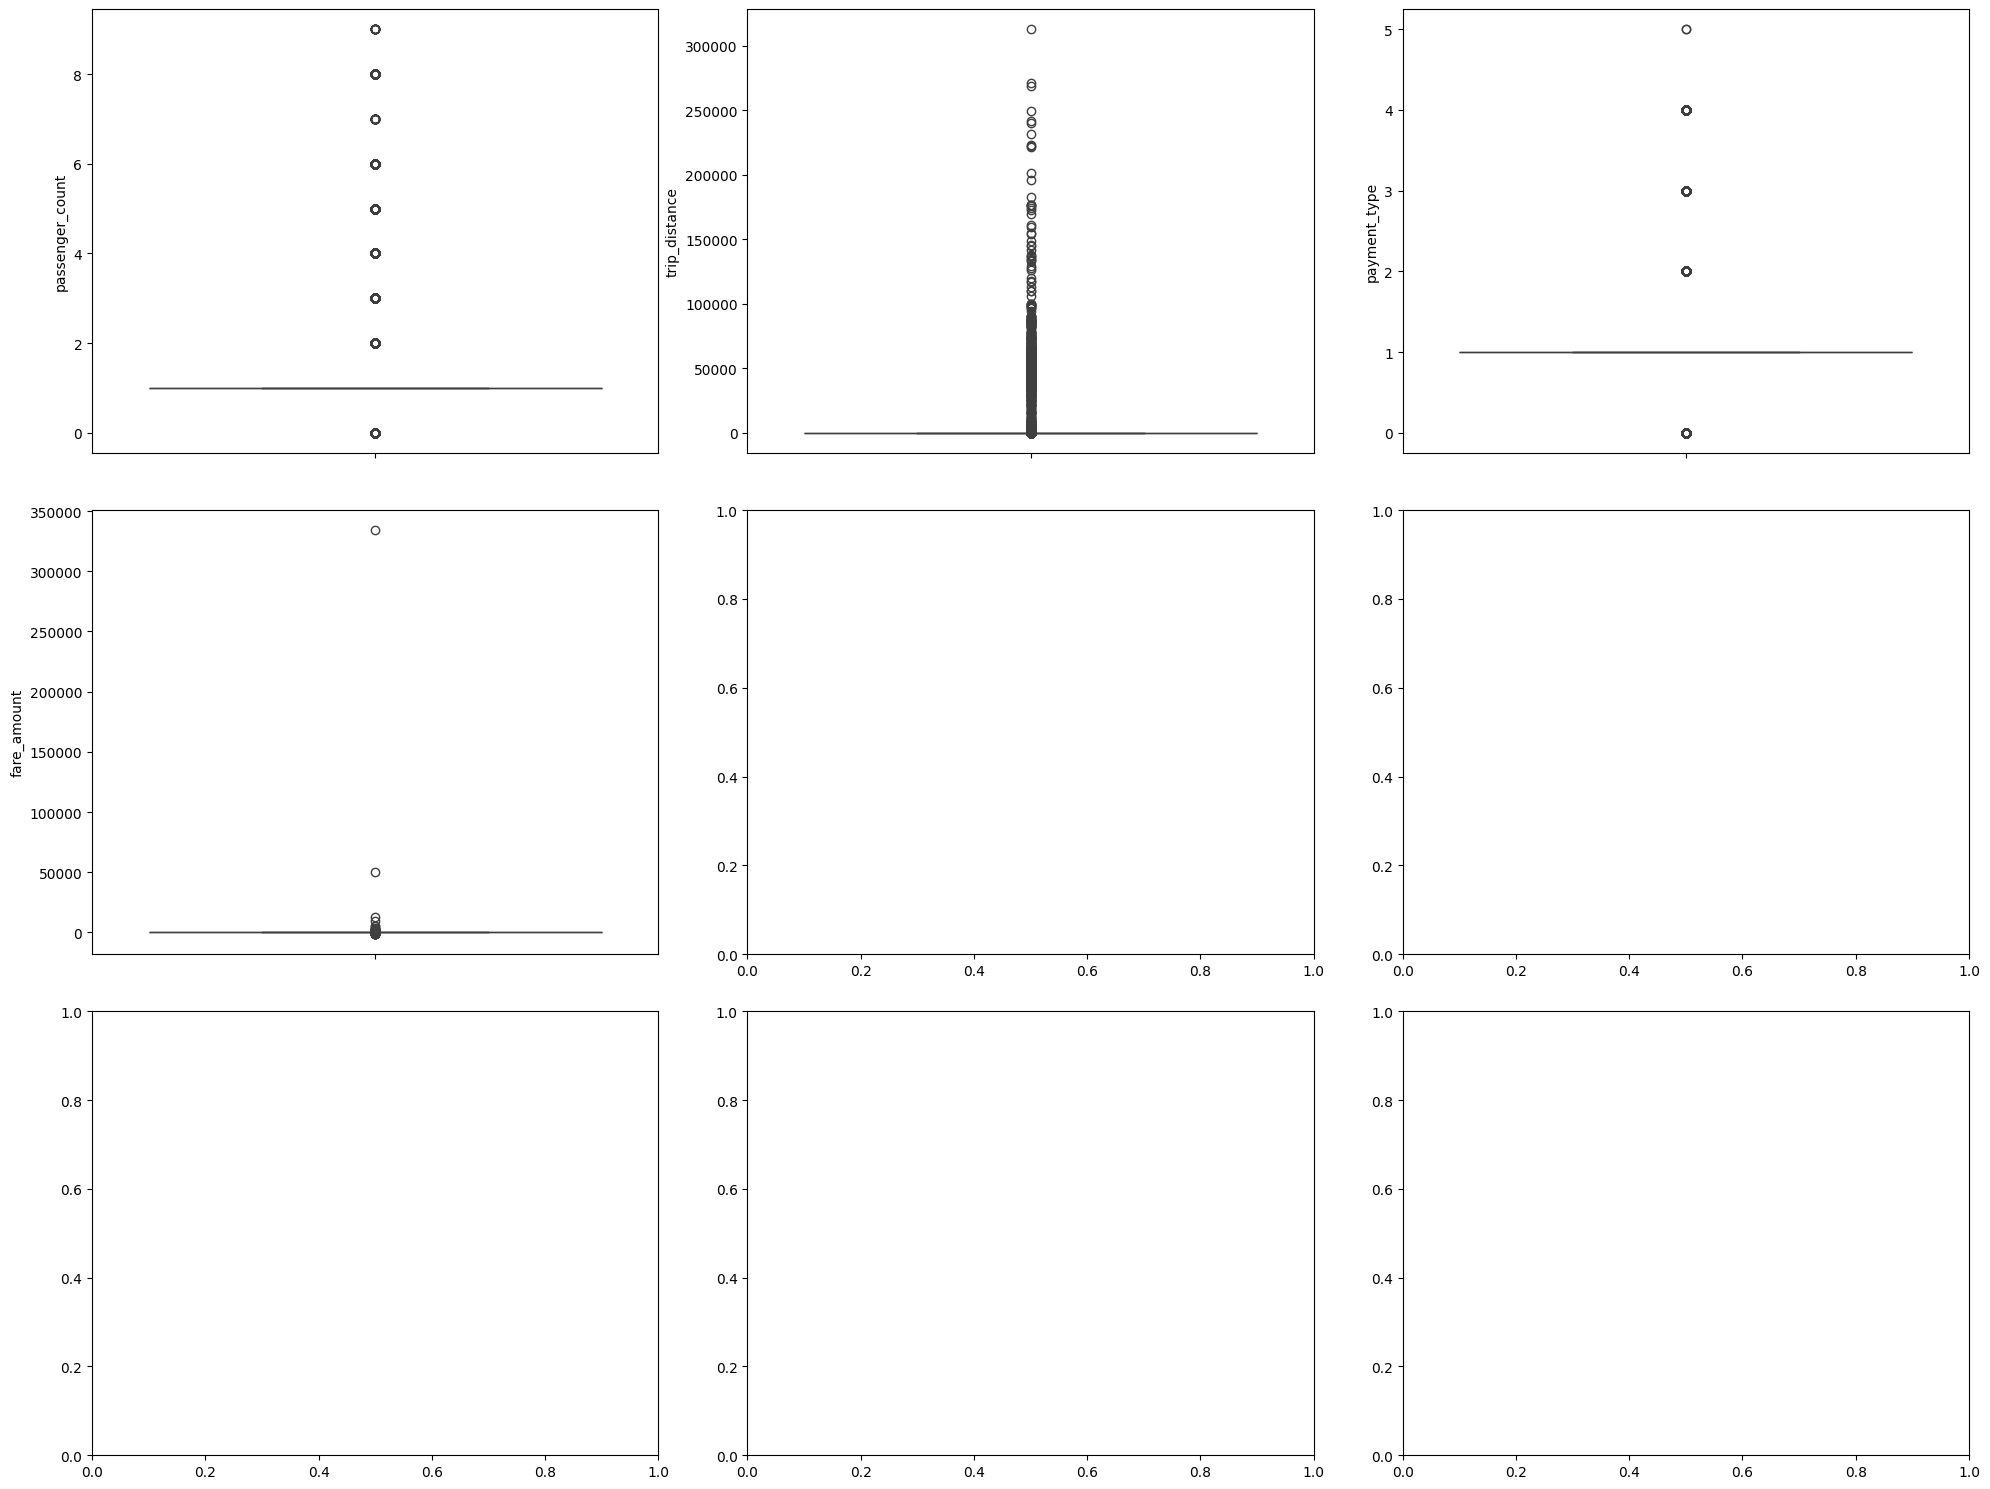

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
index = 0
axs = axs.flatten()
for k, v in df2024.select_dtypes(include=[np.number]).items():
    sns.boxplot(y=k, data=df2024, ax=axs[index])
    index += 1
plt.tight_layout(w_pad=0.5, h_pad=2)

Based on the boxplot above, it can be concluded that the dataset contains many outliers and none of them are normally distributed.

In [22]:
# fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
# index = 0
# axs = axs.flatten()
# for k, v in df2024.select_dtypes(include=[np.number]).items():
#     axs[index].set_title(k)
#     sns.displot(x=df2024[k], ax=axs[index])
#     index += 1
# plt.tight_layout(w_pad=0.5, h_pad=2)
# plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axs = axs.flatten()

# Loop through numeric columns and create histograms
index = 0
for k, v in df2024.select_dtypes(include=[np.number]).items():
    axs[index].set_title(k)
    sns.histplot(x=v, ax=axs[index], kde=True, bins=30)  # Use histplot instead of displot
    index += 1

plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()


In [ ]:

# Assuming df2024 is your DataFrame
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axs = axs.flatten()

# Loop through numeric columns and create histograms
index = 0
numeric_cols = df2024.select_dtypes(include=[np.number]).columns  # Get numeric columns
for col in numeric_cols:
    if index < len(axs):  # Ensure we don't exceed the number of subplots
        sns.histplot(df2024[col], kde=True, ax=axs[index], bins=30)
        axs[index].set_title(col, fontsize=12)
        index += 1

# Adjust layout
plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()


In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df2024.corr('spearman'), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

## Data Cleaning

In [13]:
df2024[df2024.duplicated()]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
6956,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.970000,2,0.0
15731,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.860000,2,0.0
20848,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.000000,2,0.0
20850,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.000000,2,0.0
40344,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.000000,2,0.0
...,...,...,...,...,...,...
3100952,2024-06-30 16:46:29,2024-06-30 17:51:54,2.0,19.100000,2,0.0
3105908,2024-06-30 17:53:49,2024-06-30 17:53:56,4.0,0.000000,2,0.0
3106542,2024-06-30 17:24:58,2024-06-30 17:25:47,4.0,0.000000,2,0.0
3121861,2024-06-30 21:12:57,2024-06-30 21:41:15,2.0,21.879999,2,0.0


In [14]:
df2024.drop_duplicates(inplace= True)

In [15]:
duplicate_value = df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,4,-13.500000
100,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,4,13.500000
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,2,-31.500000
507,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,2,31.500000
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,4,-5.800000
...,...,...,...,...,...,...
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,0,19.480000
3372158,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,0,18.920000
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,0,17.370001
3405783,2024-06-21 18:55:00,2024-06-21 19:11:00,NaN,2.21,0,18.110001


In [16]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,4,-13.500000
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,2,-31.500000
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,4,-5.800000
552,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,2,-33.099998
682,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,4,-47.799999
...,...,...,...,...,...,...
3128236,2024-06-30 23:03:55,2024-06-30 23:12:30,3.0,0.91,4,-6.500000
3128264,2024-06-30 23:47:55,2024-07-01 00:36:20,2.0,5.38,4,-43.599998
3128357,2024-06-30 23:19:00,2024-06-30 23:54:15,2.0,17.77,4,-70.000000
3128387,2024-06-30 23:47:08,2024-06-30 23:47:13,1.0,0.00,3,-86.000000


In [17]:
df2024.drop(dup_negative_val.index, inplace=True)

In [18]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
171767,2024-01-03 12:57:37,2024-01-03 12:57:43,1.0,0.00,2,3.000000
720867,2024-01-09 17:43:44,2024-01-09 17:47:10,1.0,0.53,1,5.800000
1121584,2024-01-13 20:04:20,2024-01-13 20:04:25,1.0,0.00,1,85.099998
1844017,2024-01-21 17:39:15,2024-01-21 17:42:59,1.0,0.80,1,6.500000
2352940,2024-01-26 23:39:03,2024-01-26 23:51:27,1.0,2.00,1,13.500000
...,...,...,...,...,...,...
3269203,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,0,27.440001
3320358,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,0,20.860001
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,0,19.480000
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,0,17.370001


In [19]:
df2024.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,2,17.700001
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1,10.000000
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1,23.299999
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1,10.000000
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1,7.900000
...,...,...,...,...,...,...
3539188,2024-06-30 23:07:36,2024-06-30 23:18:35,NaN,2.51,0,21.090000
3539189,2024-06-30 23:46:07,2024-07-01 00:11:53,NaN,7.55,0,33.959999
3539190,2024-06-30 23:18:50,2024-06-30 23:35:09,NaN,4.25,0,21.010000
3539191,2024-06-30 23:33:36,2024-06-30 23:42:37,NaN,1.60,0,14.410000


In [20]:
df2024.shape

(18867985, 6)

In [21]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
171767,2024-01-03 12:57:37,2024-01-03 12:57:43,1.0,0.00,2,3.000000
720867,2024-01-09 17:43:44,2024-01-09 17:47:10,1.0,0.53,1,5.800000
1121584,2024-01-13 20:04:20,2024-01-13 20:04:25,1.0,0.00,1,85.099998
1844017,2024-01-21 17:39:15,2024-01-21 17:42:59,1.0,0.80,1,6.500000
2352940,2024-01-26 23:39:03,2024-01-26 23:51:27,1.0,2.00,1,13.500000
...,...,...,...,...,...,...
3269203,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,0,27.440001
3320358,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,0,20.860001
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,0,19.480000
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,0,17.370001


In [22]:
print(df2024.index.duplicated().sum())

15391942


In [23]:
df2024.reset_index(drop=True, inplace=True)

In [24]:
print(df2024.index.duplicated().sum())

0


In [25]:
df2024.shape

(18867985, 6)

In [26]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,neg_value(%)
0,tpep_pickup_datetime,0.000
1,tpep_dropoff_datetime,0.000
2,passenger_count,0.000
3,trip_distance,0.000
4,payment_type,0.000
5,fare_amount,0.311


In [27]:
negative_val  = df2024[df2024['fare_amount']<0]
df2024.loc[negative_val.index, 'fare_amount'] = df2024['fare_amount'].abs()

In [28]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,data_type,0_value(%)
0,tpep_pickup_datetime,datetime64[us],0.000
1,tpep_dropoff_datetime,datetime64[us],0.000
2,passenger_count,float32,1.096
3,trip_distance,float32,1.713
4,payment_type,int32,10.313
5,fare_amount,float32,0.037


In [29]:
median_passenger_count = df2024[df2024['passenger_count'] > 0]['passenger_count'].median()
df2024['passenger_count'] = df2024['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df2024 = df2024[df2024['trip_distance']>0]
df2024 = df2024[df2024['fare_amount']>0]

In [30]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,tpep_pickup_datetime,datetime64[us],0.0
1,tpep_dropoff_datetime,datetime64[us],0.0
2,passenger_count,float64,0.0
3,trip_distance,float32,0.0
4,payment_type,int32,0.0
5,fare_amount,float32,0.0


In [31]:
df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)
df2024['passenger_count'].value_counts()

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_17688\2787419272.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)


passenger_count
1.0    14958727
2.0     2416826
3.0      554722
4.0      319974
5.0      172970
6.0      116795
8.0          63
7.0          13
9.0          10
Name: count, dtype: int64

In [32]:
outliers = df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]
outliers

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
239,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.380000,1,15.600000
342,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.470000,1,5.100000
1961,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.530000,1,5.800000
2310,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.970000,1,6.500000
2629,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.140000,1,17.000000
2796,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.440000,1,10.700000
3662,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.390000,2,33.099998
3666,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.590000,1,10.000000
7770,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.700000,1,33.099998
9894,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.460000,2,4.400000


In [33]:
df2024.drop(outliers.index, inplace=True)

In [34]:
df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount


In [35]:
# time_bins = [0, 5, 11, 15, 20, 24] 
# time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
# df2024['pickup_time'] = pd.cut(df2024['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# df2024['day_category'] = df2024['tpep_pickup_datetime '].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

In [36]:
df2024 = df2024[df2024['trip_distance']>1]

In [37]:
df2024[df2024['trip_distance']>120].sort_values(by='trip_distance', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
2723726,2024-01-30 06:37:00,2024-01-30 06:50:00,1.0,312722.312500,0,14.460000
12067982,2024-04-26 21:08:00,2024-04-26 21:29:00,1.0,270766.812500,0,29.219999
11832615,2024-04-08 05:19:00,2024-04-08 05:22:00,1.0,268958.218750,0,8.080000
15432506,2024-05-18 21:21:00,2024-05-18 21:31:00,1.0,249151.437500,0,16.299999
15540555,2024-05-28 08:45:00,2024-05-28 09:26:00,1.0,241289.234375,0,57.029999


In [ ]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2024['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [38]:
df2024 = df2024[df2024['trip_distance']<120]

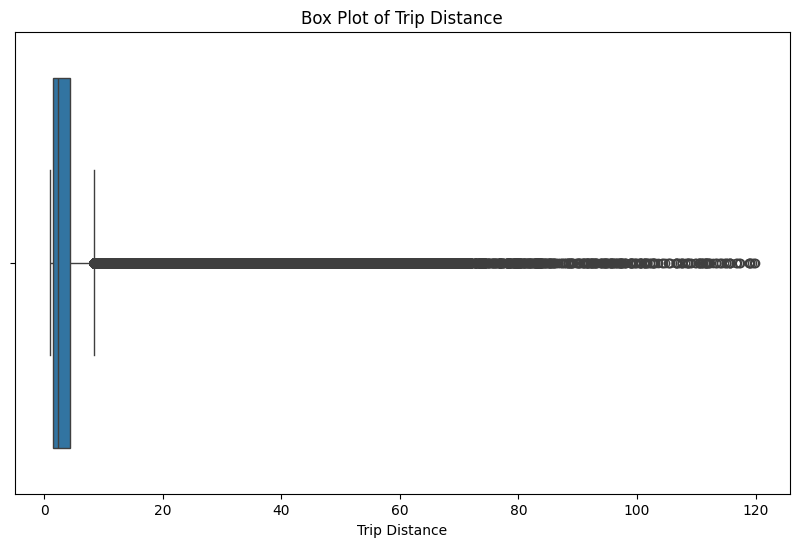

In [39]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2024['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [40]:
df2024[df2024['fare_amount']>120].sort_values(by='fare_amount', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
1068336,2024-01-14 10:08:11,2024-01-16 13:54:22,1.0,31.950001,2,2221.300049
4300803,2024-02-18 14:13:36,2024-02-18 14:16:18,1.0,1.070000,4,999.000000
5009202,2024-02-26 19:18:19,2024-02-27 15:33:07,1.0,36.200001,2,924.900024
9519235,2024-04-08 07:19:52,2024-04-08 10:48:19,1.0,115.629997,2,873.099976
5283477,2024-02-29 17:06:32,2024-02-29 20:08:18,5.0,118.870003,2,821.299988


In [41]:
diff = (df2024['tpep_dropoff_datetime'] - df2024['tpep_pickup_datetime']).dt.total_seconds()/60
df2024['trip_duration'] = diff.round(2)

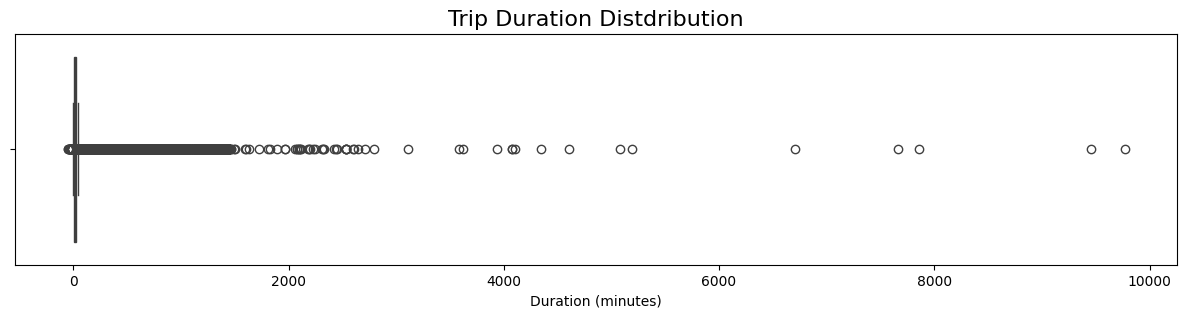

In [42]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

In [44]:
diff = (df2024['tpep_dropoff_datetime'] - df2024['tpep_pickup_datetime']).dt.total_seconds()/60
df2024['trip_duration'] = diff.round(2)

In [45]:
df2024[df2024['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,trip_duration
9592416,2024-04-08 23:16:11,2024-04-15 18:03:42,1.0,13.62,2,1.000000,9767.52
1944598,2024-01-24 17:03:14,2024-01-31 06:38:38,1.0,2.26,2,30.299999,9455.40
13006444,2024-05-09 19:03:38,2024-05-15 06:05:29,1.0,14.62,2,70.000000,7861.85
16135610,2024-06-06 16:18:13,2024-06-11 23:56:51,1.0,8.19,2,55.500000,7658.63
11116155,2024-04-24 21:36:24,2024-04-29 13:23:38,1.0,11.26,2,43.599998,6707.23


In [46]:
df2024 = df2024[df2024['trip_duration']<700]

In [47]:
df2024 = df2024[df2024['trip_duration']>0]

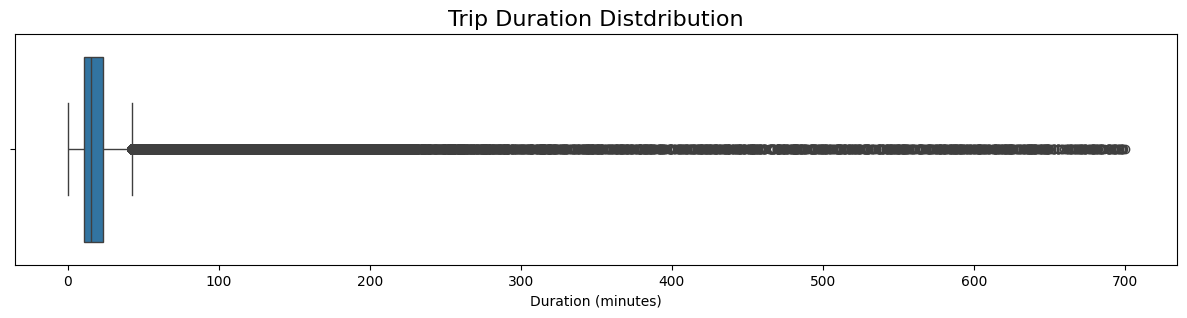

In [48]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

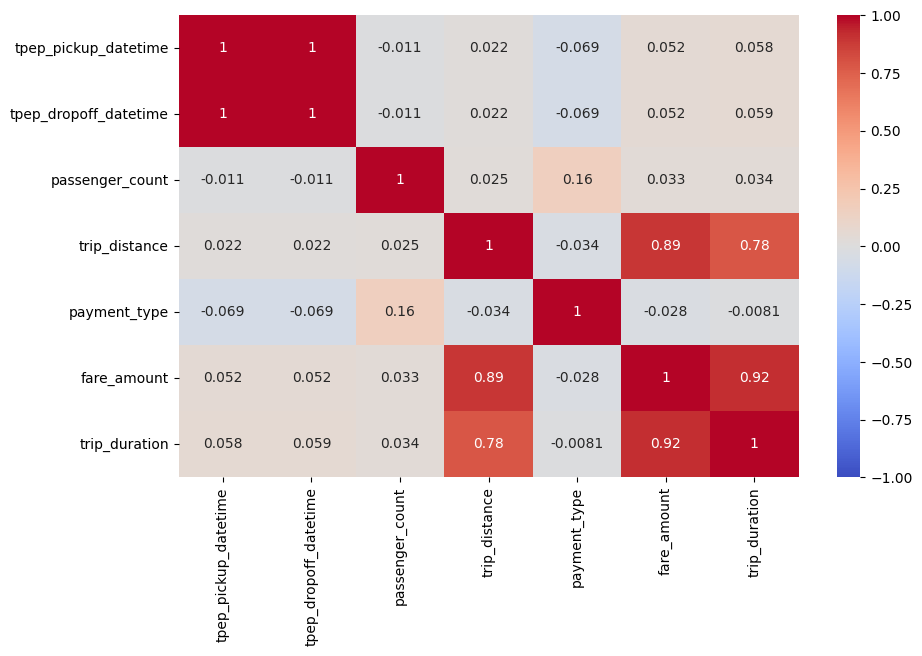

In [49]:
plt.figure(figsize=(10,6))
sns.heatmap(df2024.corr('spearman'), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

In [50]:
# Extract hour, day of the week, month, and season from pickup datetime
df2024['hour'] = df2024['tpep_pickup_datetime'].dt.hour
df2024['day_of_week'] = df2024['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2024['month'] = df2024['tpep_pickup_datetime'].dt.month

KeyboardInterrupt: 

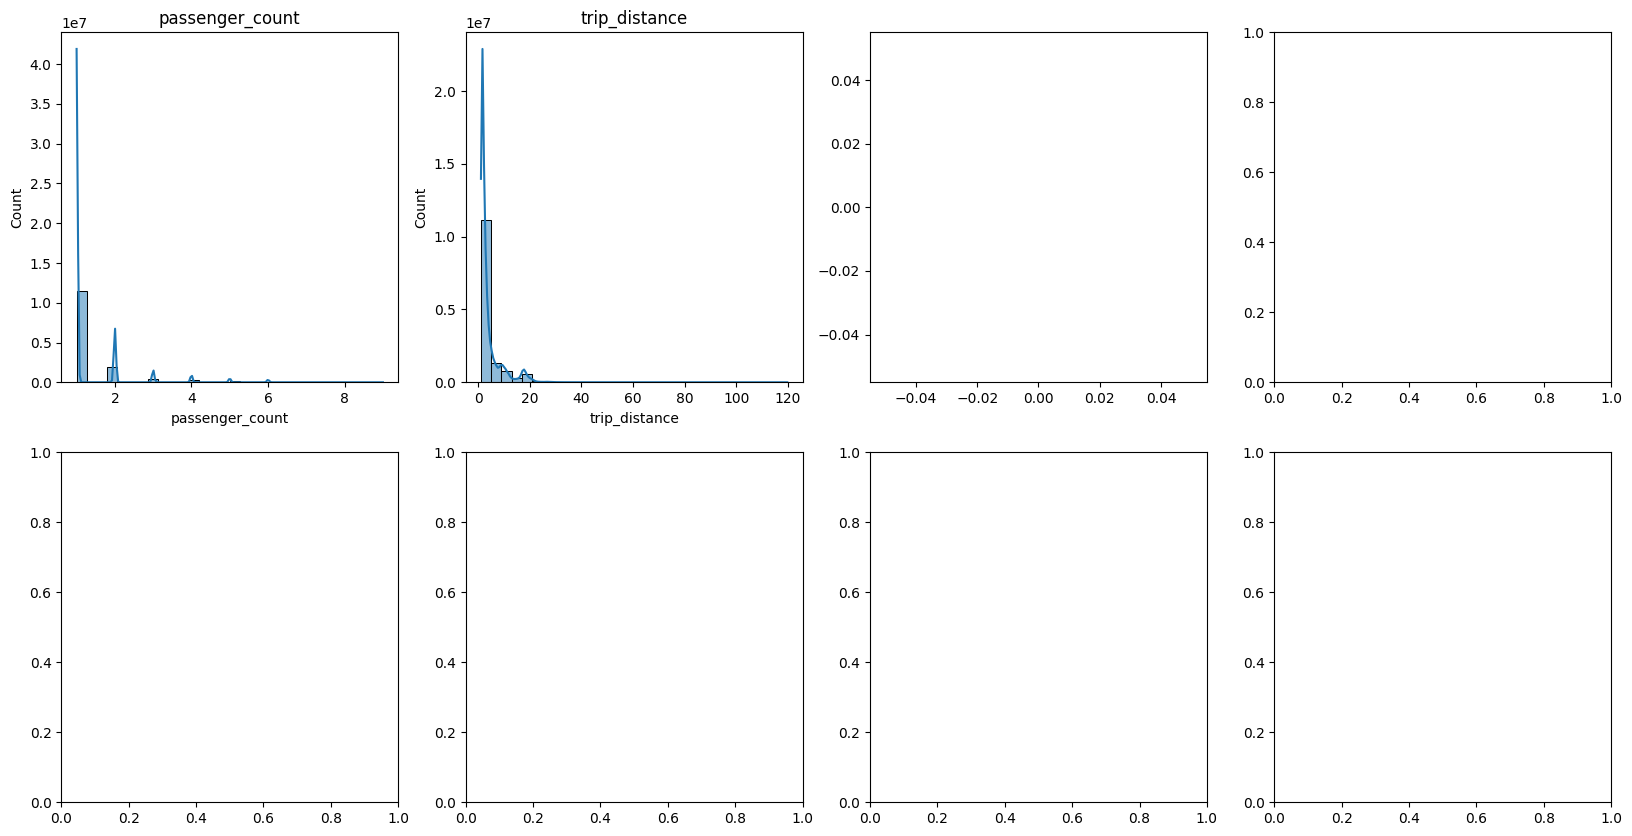

In [51]:

# Assuming df2024 is your DataFrame
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axs = axs.flatten()

# Loop through numeric columns and create histograms
index = 0
numeric_cols = df2024.select_dtypes(include=[np.number]).columns  # Get numeric columns
for col in numeric_cols:
    if index < len(axs):  # Ensure we don't exceed the number of subplots
        sns.histplot(df2024[col], kde=True, ax=axs[index], bins=30)
        axs[index].set_title(col, fontsize=12)
        index += 1

# Adjust layout
plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()


## Regression

In [52]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14264043 entries, 0 to 18867984
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float32       
 4   payment_type           int32         
 5   fare_amount            float32       
 6   trip_duration          float64       
 7   hour                   int32         
 8   day_of_week            int32         
 9   month                  int32         
dtypes: datetime64[us](2), float32(2), float64(2), int32(4)
memory usage: 870.6 MB


In [53]:
# Cross-validation function for regression
def cross_validate_models(X, y):
    # Initialize models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso": Lasso(alpha=1.0),  # Adjust alpha if needed
        "Ridge": Ridge(alpha=1.0),  # Adjust alpha if needed
        "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)  # Adjust alpha and l1_ratio if needed
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Cross-validation with cross_val_score for RMSE
        scores_rmse = cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_R2": r2_pred
        })
        pd.DataFrame(results)
    
    return pd.DataFrame(results)

In [54]:
X = df2024.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime'])
y = df2024['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_dfwithouthyperpams = cross_validate_models(X, y)
results_dfwithouthyperpams

,Model,Cross_val_score_RMSE,Cross_val_predict_RMSE,Cross_val_predict_MAE,Cross_val_predict_R2
0,Linear Regression,5.766555,5.766571,2.578122,0.898189
1,Lasso,5.781317,5.781335,2.561101,0.897667
2,Ridge,5.766555,5.766571,2.578122,0.898189
3,ElasticNet,5.805480,5.805502,2.499029,0.896810


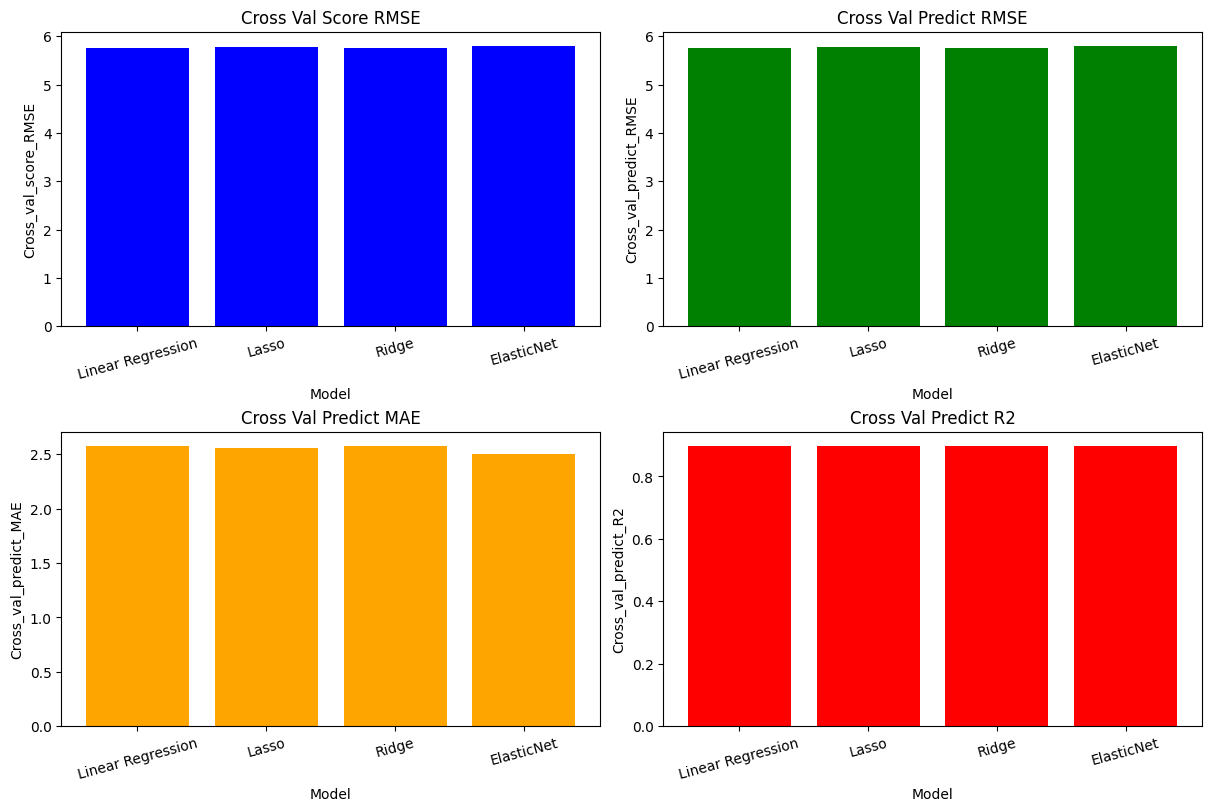

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame from the given data
data = {
    "Model": ["Linear Regression", "Lasso", "Ridge", "ElasticNet"],
    "Cross_val_score_RMSE": [5.766555, 5.781317, 5.766555, 5.805480],
    "Cross_val_predict_RMSE": [5.766571, 5.781335, 5.766571, 5.805502],
    "Cross_val_predict_MAE": [2.578122, 2.561101, 2.578122, 2.499029],
    "Cross_val_predict_R2": [0.898189, 0.897667, 0.898189, 0.896810]
}
results_dfwithouthyperpams = pd.DataFrame(data)

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
metrics = ["Cross_val_score_RMSE", "Cross_val_predict_RMSE", "Cross_val_predict_MAE", "Cross_val_predict_R2"]
titles = ["Cross Val Score RMSE", "Cross Val Predict RMSE", "Cross Val Predict MAE", "Cross Val Predict R2"]
colors = ['blue', 'green', 'orange', 'red']

for i, ax in enumerate(axes.flat):
    ax.bar(results_dfwithouthyperpams["Model"], results_dfwithouthyperpams[metrics[i]], color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel("Model")
    ax.set_ylabel(metrics[i])
    ax.tick_params(axis='x', rotation=15)

# Show the plot
plt.show()


In [ ]:

# Function for cross-validation with hyperparameter tuning
def cross_validate_models_with_hyperparams(X, y):
    # Define models and their hyperparameter grids
    model_params = {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {}  # No hyperparameters to tune for Linear Regression
        },
        "Lasso": {
            "model": Lasso(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "Ridge": {
            "model": Ridge(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "params": {
                "alpha": np.logspace(-3, 1, 5),  # Regularization strength
                "l1_ratio": [0.1, 0.5, 0.9]     # Balance between L1 and L2
            }
        }
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, config in model_params.items():
        model = config["model"]
        param_grid = config["params"]
        
        # Perform GridSearchCV if hyperparameters exist
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, 
                                       scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model
            best_params = "Default (No hyperparams)"
        
        # Cross-validation with the best model
        scores_rmse = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_R2": r2_pred
        })
    
    return pd.DataFrame(results)

In [ ]:
X = df2024.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime'])
y = df2024['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_dfwithhyperpams = cross_validate_models_with_hyperparams(X, y)
results_dfwithhyperpams

In [57]:
df_2024copy = df2024.copy()

In [58]:
df_2024copy['fare_amount'] = np.log1p(df_2024copy['fare_amount'])
df_2024copy['trip_distance'] = np.log1p(df_2024copy['trip_distance'])
df_2024copy['trip_duration'] = np.log1p(df_2024copy['trip_duration'])

In [59]:
X = df_2024copy.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime'])
y = df_2024copy['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_dflognormal = cross_validate_models(X, y)
results_dflognormal

,Model,Cross_val_score_RMSE,Cross_val_predict_RMSE,Cross_val_predict_MAE,Cross_val_predict_R2
0,Linear Regression,0.220467,0.220468,0.087064,8.612390e-01
1,Lasso,0.591850,0.591850,0.460132,-2.500040e-07
2,Ridge,0.220467,0.220468,0.087064,8.612390e-01
3,ElasticNet,0.591850,0.591850,0.460132,-2.500040e-07


In [61]:
df_2024copy2 = df2024.copy()
df_2024copy2['trip_distance'] = np.log1p(df_2024copy2['trip_distance'])
df_2024copy2['trip_duration'] = np.log1p(df_2024copy2['trip_duration'])
X = df_2024copy2.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime'])
y = df_2024copy2['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_dflognormalwithoutfare = cross_validate_models(X, y)
results_dflognormalwithoutfare

,Model,Cross_val_score_RMSE,Cross_val_predict_RMSE,Cross_val_predict_MAE,Cross_val_predict_R2
0,Linear Regression,7.852399,7.852430,4.411881,0.811216
1,Lasso,8.091579,8.091612,4.195437,0.799540
2,Ridge,7.852399,7.852430,4.411880,0.811216
3,ElasticNet,11.206890,11.206910,6.253257,0.615471


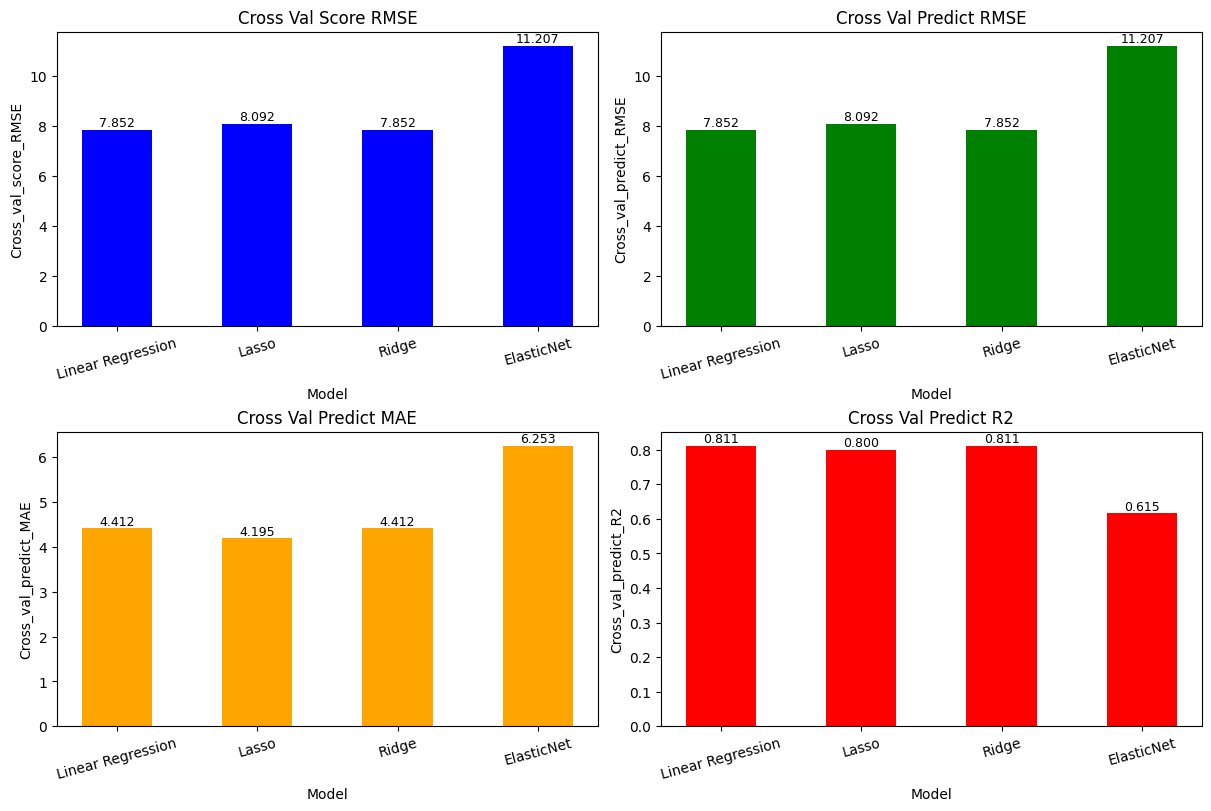

In [62]:

# Bar chart with thinner bars and values on top
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Adjust the bar width
bar_width = 0.5

# Data and properties
metrics = ["Cross_val_score_RMSE", "Cross_val_predict_RMSE", "Cross_val_predict_MAE", "Cross_val_predict_R2"]
titles = ["Cross Val Score RMSE", "Cross Val Predict RMSE", "Cross Val Predict MAE", "Cross Val Predict R2"]
colors = ['blue', 'green', 'orange', 'red']

# Create subplots
for i, ax in enumerate(axes.flat):
    bars = ax.bar(results_dflognormalwithoutfare["Model"], results_dflognormalwithoutfare[metrics[i]], width=bar_width, color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel("Model")
    ax.set_ylabel(metrics[i])
    ax.tick_params(axis='x', rotation=15)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Show the plot
plt.show()


In [63]:
df_2024copy3 = df2024.copy()
df_2024copy3['fare_amount'] = np.log1p(df_2024copy3['fare_amount'])
X = df_2024copy3.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime'])
y = df_2024copy3['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
results_dflognormalwithonlyfare = cross_validate_models(X, y)
results_dflognormalwithonlyfare

,Model,Cross_val_score_RMSE,Cross_val_predict_RMSE,Cross_val_predict_MAE,Cross_val_predict_R2
0,Linear Regression,0.296767,0.296768,0.193333,0.748574
1,Lasso,0.385268,0.385271,0.250987,0.576251
2,Ridge,0.296767,0.296768,0.193333,0.748574
3,ElasticNet,0.324271,0.324274,0.211705,0.699806


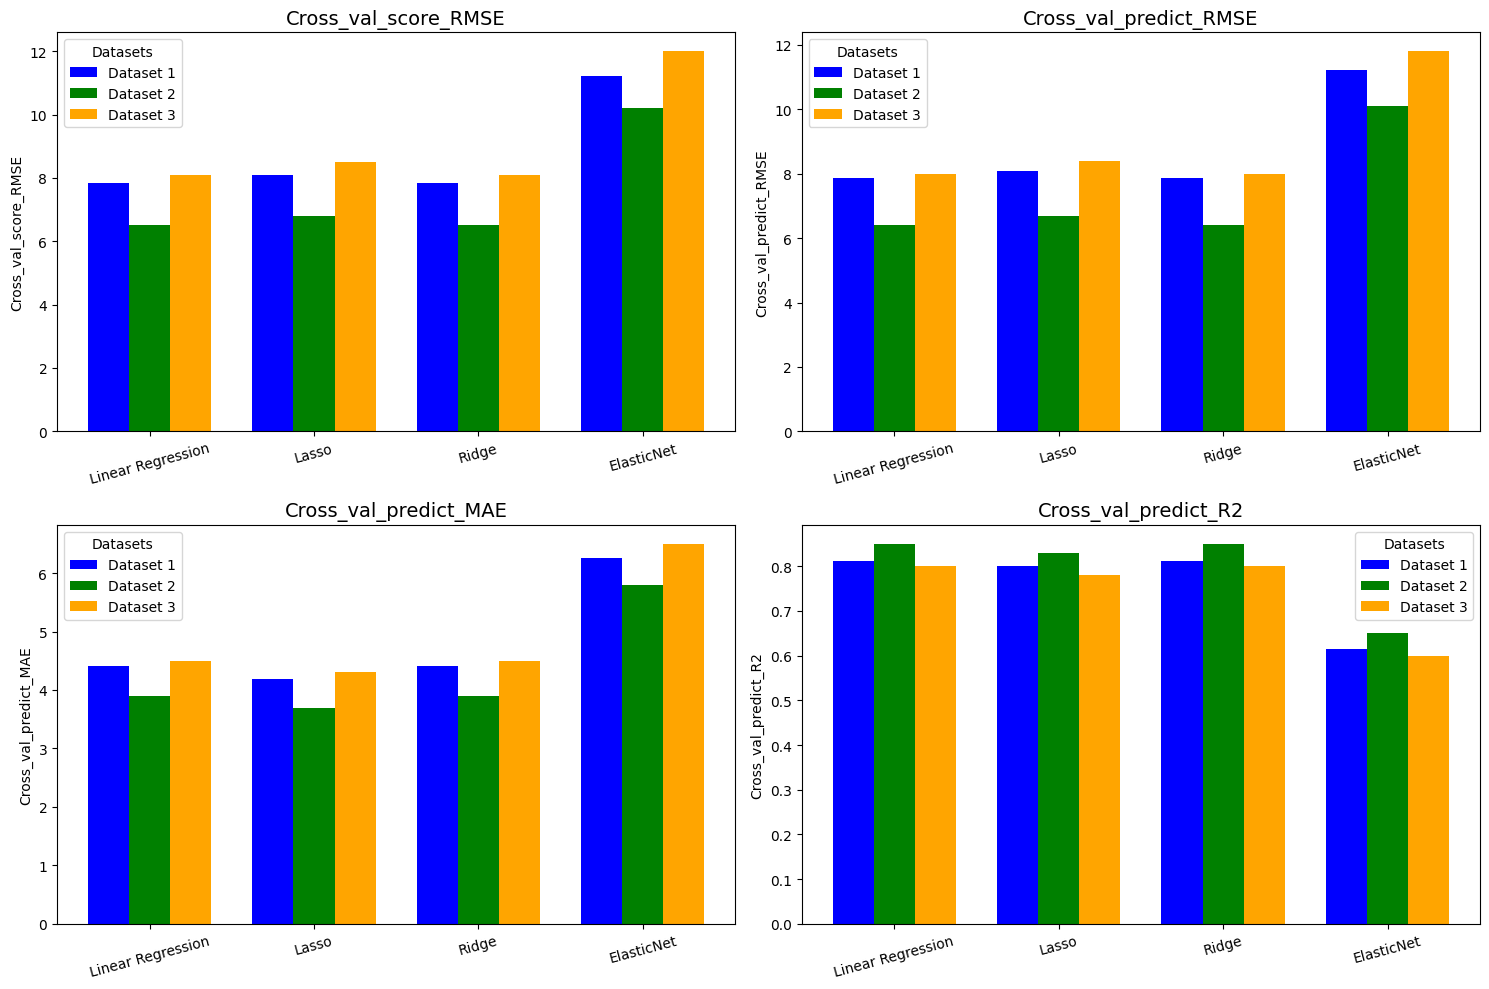

In [64]:

# Example DataFrames for three datasets (replace these with your actual data)
datasets = {
    "Dataset 1": {
        "Model": ["Linear Regression", "Lasso", "Ridge", "ElasticNet"],
        "Cross_val_score_RMSE": [7.852399, 8.091579, 7.852399, 11.206890],
        "Cross_val_predict_RMSE": [7.852430, 8.091612, 7.852430, 11.206910],
        "Cross_val_predict_MAE": [4.411881, 4.195437, 4.411880, 6.253257],
        "Cross_val_predict_R2": [0.811216, 0.799540, 0.811216, 0.615471],
    },
    "Dataset 2": {
        "Model": ["Linear Regression", "Lasso", "Ridge", "ElasticNet"],
        "Cross_val_score_RMSE": [6.5, 6.8, 6.5, 10.2],
        "Cross_val_predict_RMSE": [6.4, 6.7, 6.4, 10.1],
        "Cross_val_predict_MAE": [3.9, 3.7, 3.9, 5.8],
        "Cross_val_predict_R2": [0.85, 0.83, 0.85, 0.65],
    },
    "Dataset 3": {
        "Model": ["Linear Regression", "Lasso", "Ridge", "ElasticNet"],
        "Cross_val_score_RMSE": [8.1, 8.5, 8.1, 12.0],
        "Cross_val_predict_RMSE": [8.0, 8.4, 8.0, 11.8],
        "Cross_val_predict_MAE": [4.5, 4.3, 4.5, 6.5],
        "Cross_val_predict_R2": [0.80, 0.78, 0.80, 0.60],
    },
}

# Metrics to plot
metrics = ["Cross_val_score_RMSE", "Cross_val_predict_RMSE", "Cross_val_predict_MAE", "Cross_val_predict_R2"]

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["blue", "green", "orange"]  # One color per dataset
bar_width = 0.25  # Width of each bar
x_indices = np.arange(len(datasets["Dataset 1"]["Model"]))  # Positions for groups

# Loop through each metric and create a grouped bar chart
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        values = dataset[metric]
        ax.bar(
            x_indices + i * bar_width, 
            values, 
            width=bar_width, 
            label=dataset_name, 
            color=colors[i]
        )
    
    # Configure plot
    ax.set_title(metric, fontsize=14)
    ax.set_xticks(x_indices + bar_width)
    ax.set_xticklabels(datasets["Dataset 1"]["Model"], rotation=15)
    ax.set_ylabel(metric)
    ax.legend(title="Datasets")

# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:

results_dflognormalhyperpams = cross_validate_models_with_hyperparams(X, y)
results_dflognormalhyperpams

In [ ]:
# Import additional metrics
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

# Function for cross-validation with hyperparameter tuning and additional metrics
def cross_validate_models_with_hyperparams(X, y):
    # Define models and their hyperparameter grids
    model_params = {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {}  # No hyperparameters to tune for Linear Regression
        },
        "Lasso": {
            "model": Lasso(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "Ridge": {
            "model": Ridge(),
            "params": {"alpha": np.logspace(-3, 1, 5)}  # Hyperparameter: alpha
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "params": {
                "alpha": np.logspace(-3, 1, 5),  # Regularization strength
                "l1_ratio": [0.1, 0.5, 0.9]     # Balance between L1 and L2
            }
        }
    }

    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, config in model_params.items():
        model = config["model"]
        param_grid = config["params"]
        
        # Perform GridSearchCV if hyperparameters exist
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, 
                                       scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model
            best_params = "Default (No hyperparams)"
        
        # Cross-validation with the best model
        scores_rmse = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = root_mean_squared_error(y, y_pred)
        mae_pred = mean_absolute_error(y, y_pred)
        mape_pred = mean_absolute_percentage_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        evs_pred = explained_variance_score(y, y_pred)
        
        # Store results
        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_MAPE": mape_pred,
            "Cross_val_predict_R2": r2_pred,
            "Cross_val_predict_EVS": evs_pred
        })
    
    return pd.DataFrame(results)

# Example usage
metrics_df = cross_validate_models_with_hyperparams(X, y)
print(metrics_df)


In [ ]:
df_2024copyStandardized = df_2024copy.copy()
scaler = StandardScaler()
X = df_2024copyStandardized.drop(columns=['fare_amount','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID'])
y = df_2024copyStandardized['fare_amount']
X = pd.get_dummies(X, columns=['payment_type' ], drop_first=True)
X = scaler.fit_transform(X)
results_df = cross_validate_models(X, y)
results_df

In [ ]:
df2024.info()

In [ ]:
# Extract hour, day of the week, month, and season from pickup datetime
df2024['hour'] = df2024['tpep_pickup_datetime'].dt.hour
df2024['day_of_week'] = df2024['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2024['month'] = df2024['tpep_pickup_datetime'].dt.month

In [71]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14264043 entries, 0 to 18867984
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float32       
 4   payment_type           int32         
 5   fare_amount            float32       
 6   trip_duration          float64       
 7   hour                   int32         
 8   day_of_week            int32         
 9   month                  int32         
dtypes: datetime64[us](2), float32(2), float64(2), int32(4)
memory usage: 870.6 MB


C:\Users\ujjwa\AppData\Local\Temp\ipykernel_17688\2667360682.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=trip_count_by_day.index, y=trip_count_by_day.values, palette=color)


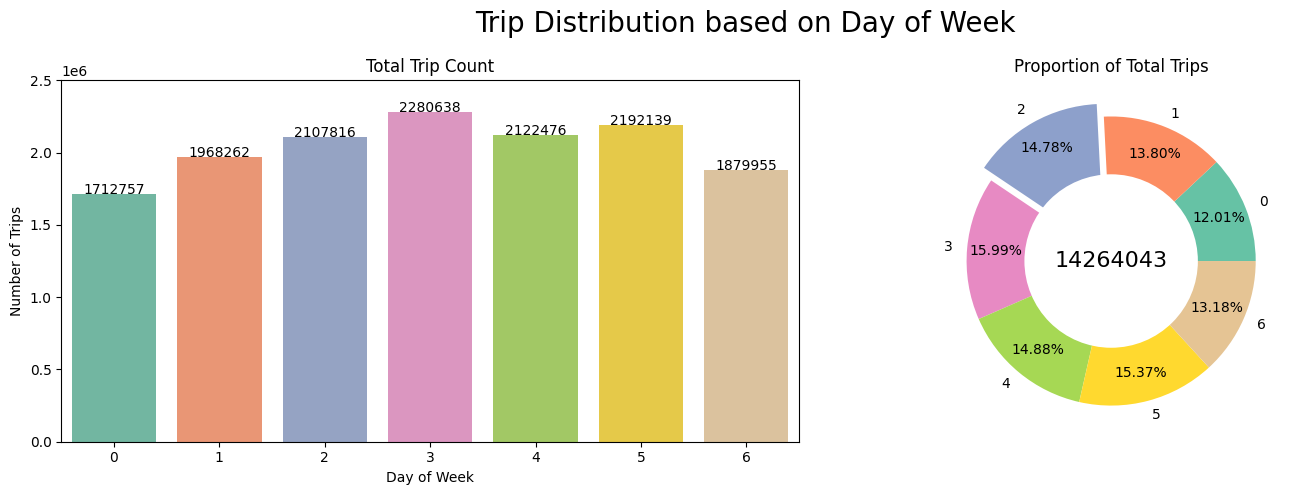

In [ ]:

# Calculate the count of trips for each day of the week
trip_count_by_day = df2024.groupby('day_of_week').size()

# Choose a color palette
color = sns.color_palette("Set2", len(trip_count_by_day))

# Create the plot
plt.figure(figsize=(15, 5))
plt.suptitle('Trip Distribution based on Day of Week', fontsize=20)

# Left side: Barplot of Total Trip Count
plt.subplot(1, 2, 1)
bars = sns.barplot(x=trip_count_by_day.index, y=trip_count_by_day.values, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 20
    label = "{:.0f}".format(trip_count_by_day.values[idx]) 
    plt.text(x_value, y_value, label, ha='center')

plt.title('Total Trip Count')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.yticks(np.arange(0, max(trip_count_by_day.values) + 500000, 500000))

# Right side: Pie Chart of Total Trips by Day of Week
plt.subplot(1, 2, 2)
plt.pie(trip_count_by_day.values, 
        labels=trip_count_by_day.index, 
        pctdistance=0.8, 
        autopct='%1.2f%%', 
        explode=(0, 0, 0.1, 0, 0, 0, 0),  # Optional: Highlight one segment
        colors=color)
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig.gca().add_artist(centre_circle)
plt.text(0, 0, trip_count_by_day.sum(), ha='center', va='center', fontsize=16)
plt.title('Proportion of Total Trips')

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\ujjwa\AppData\Local\Temp\ipykernel_17688\275455489.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=trip_count_by_day.index, y=trip_count_by_day.values, palette=color)


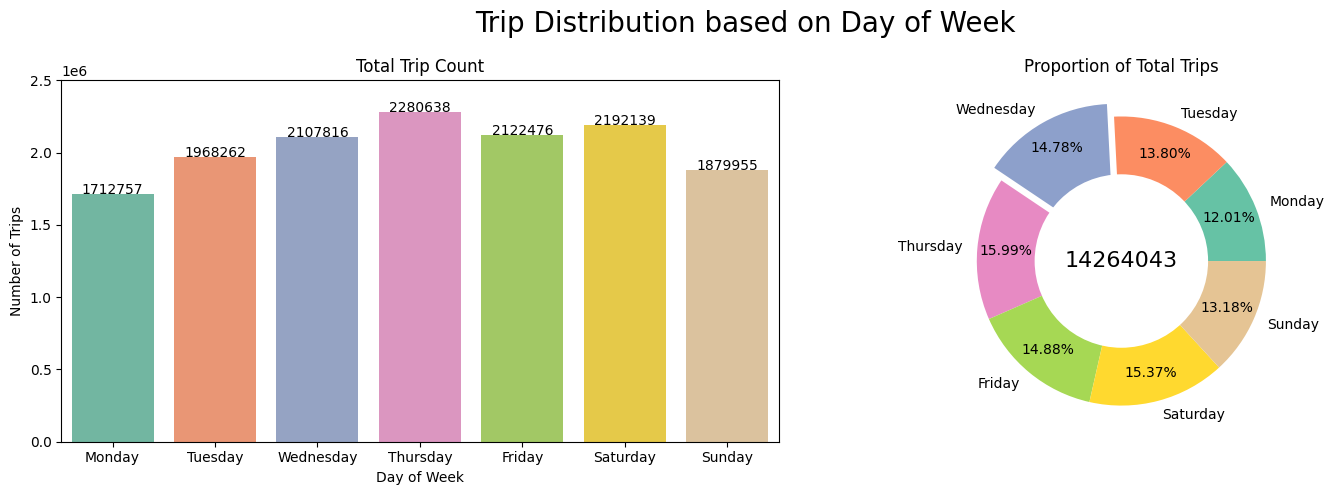

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Map day_of_week values (0 to 6) to day names
day_name_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Calculate the count of trips for each day of the week
trip_count_by_day = df2024.groupby('day_of_week').size()

# Apply the mapping for day names
trip_count_by_day.index = trip_count_by_day.index.map(day_name_map)

# Choose a color palette
color = sns.color_palette("Set2", len(trip_count_by_day))

# Create the plot
plt.figure(figsize=(15, 5))
plt.suptitle('Trip Distribution based on Day of Week', fontsize=20)

# Left side: Barplot of Total Trip Count
plt.subplot(1, 2, 1)
bars = sns.barplot(x=trip_count_by_day.index, y=trip_count_by_day.values, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 20
    label = "{:.0f}".format(trip_count_by_day.values[idx]) 
    plt.text(x_value, y_value, label, ha='center')

plt.title('Total Trip Count')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.yticks(np.arange(0, max(trip_count_by_day.values) + 500000, 500000))

# Right side: Pie Chart of Total Trips by Day of Week
plt.subplot(1, 2, 2)
plt.pie(trip_count_by_day.values, 
        labels=trip_count_by_day.index, 
        pctdistance=0.8, 
        autopct='%1.2f%%', 
        explode=(0, 0, 0.1, 0, 0, 0, 0),  # Optional: Highlight one segment
        colors=color)
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig.gca().add_artist(centre_circle)
plt.text(0, 0, trip_count_by_day.sum(), ha='center', va='center', fontsize=16)
plt.title('Proportion of Total Trips')

# Adjust layout
plt.tight_layout()
plt.show()
